In [ ]:
# This quantifies the quality of the host star subtraction in the Altair pipeline

# Created 2019 Apr. 24 by E.S.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
from astropy.io import fits
from regions import PixCoord, CirclePixelRegion

In [36]:
# read in cube of host-star-subtracted images

stem = "/Users/nyumbani/Documents/git.repos/lbti_altair_fizeau/"
img_string = "junk_stack_frames_04259to11000.fits"
cube_subtracted, header = fits.getdata(stem+img_string,0,header=True)

In [39]:
PS_lmir = 10.7 # mas per pixel
mas_per_rad = np.divide(1000.*360.*3600.,2*np.pi)

In [42]:
def lambda_D_pix(wavel, D):
    '''
    lambda/D, in pixels on LMIRcam
    
    INPUTS:
    wavel: wavelength in m
    D: diameter in m
    
    OUTPUTS:
    l_D_pix: lambda/D in pixels
    '''
    
    l_D_pix = np.divide(wavel,D)*np.divide(mas_per_rad,PS_lmir)
    
    return l_D_pix

In [101]:
example_sci, header_sci = fits.getdata("lm_180507_009030.fits",0,header=True)

# Try one image first

In [102]:
test_image = np.squeeze(cube_subtracted[0,:,:])
#test_image = example_sci

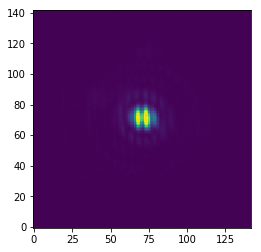

In [104]:
plt.imshow(test_image, origin="lower")
plt.show()

In [105]:
circ_rad = lambda_D_pix(4.0E-6, 8.4)
circle_reg = CirclePixelRegion(center=PixCoord(x=int(0.5*np.shape(cube_subtracted)[2]),
                                               y=int(0.5*np.shape(cube_subtracted)[1])), 
                                               radius=5*circ_rad)

In [106]:
circ_mask = circle_reg.to_mask()
mask_nans = np.copy(circ_mask.data)
mask_nans[mask_nans == 0] = np.nan

In [107]:
global_mask = np.nan*np.ones(np.shape(test_image))
global_mask[circ_mask.bbox.slices] = mask_nans

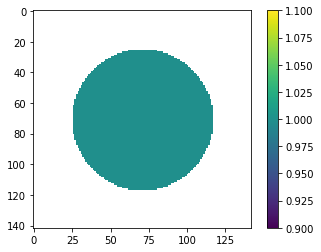

In [108]:
plt.imshow(global_mask)
plt.colorbar()
plt.show()

In [109]:
data_by_region = np.multiply(test_image,global_mask.data)

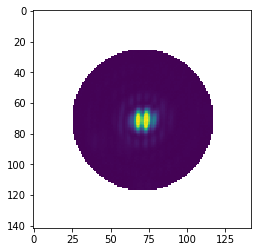

In [110]:
plt.imshow(data_by_region)
plt.show()

In [111]:
data_by_region_zeros = np.copy(data_by_region)
data_by_region_zeros = np.nan_to_num(data_by_region)

In [112]:
smoothed_data_w_zeros = scipy.ndimage.filters.gaussian_filter(data_by_region_zeros, 
                                                 sigma = circ_rad)

/Users/nyumbani/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


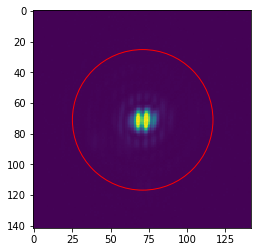

In [113]:
fig, ax = plt.subplots()

ax.imshow(test_image)
circle_reg.plot(ax=ax, color='red')
plt.show()

In [114]:
data_by_region_zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

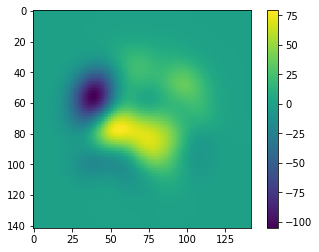

In [115]:
plt.imshow(smoothed_wo_fake_planet2)
plt.colorbar()
plt.show()

In [116]:
smoothed_data_w_zeros_by_region = np.multiply(smoothed_data_w_zeros,global_mask.data)

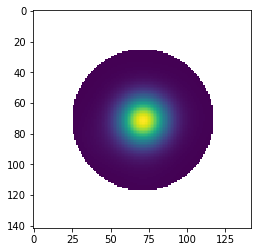

In [117]:
plt.imshow(smoothed_data_w_zeros_by_region)
plt.show()

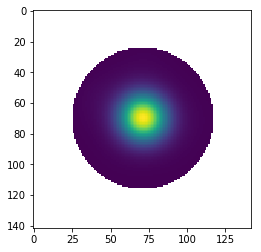

In [118]:
plt.imshow(np.flip(smoothed_data_w_zeros_by_region, axis=0))
plt.show()

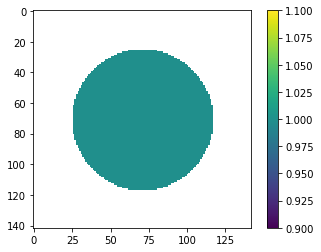

In [119]:
# to check centering

diff_img = np.subtract(global_mask, 
                       np.flip(global_mask, axis=1))

plt.imshow(global_mask)
plt.colorbar()
plt.show()

In [120]:
np.nanstd(data_by_region)

6328.472097996134

In [121]:
np.nanmax(smoothed_data_w_zeros_by_region)

12397.2410823

In [122]:
np.nanstd(smoothed_data_w_zeros_by_region)

2493.136411419446

# Now turn it into a for-loop

In [81]:
circ_rad = lambda_D_pix(4.0E-6, 8.4)
circle_reg = CirclePixelRegion(center=PixCoord(x=int(0.5*np.shape(cube_subtracted)[2]),
                                               y=int(0.5*np.shape(cube_subtracted)[1])), 
                                               radius=5*circ_rad)

circ_mask = circle_reg.to_mask()
mask_nans = np.copy(circ_mask.data)
mask_nans[mask_nans == 0] = np.nan

global_mask = np.nan*np.ones(np.shape(cube_subtracted[0,:,:]))
global_mask[circ_mask.bbox.slices] = mask_nans

quality_metric_array = pd.DataFrame({'std_unsmoothed': [], 
                               'std_smoothed': [], 
                               'max_smoothed': []})

for slice_num in range(0,np.shape(cube_subtracted)[0]):
    
    this_slice = np.squeeze(cube_subtracted[slice_num,:,:])
    
    data_by_region = np.multiply(this_slice,global_mask.data)
    
    data_by_region_zeros = np.copy(data_by_region)
    data_by_region_zeros = np.nan_to_num(data_by_region)
    
    smoothed_data_w_zeros = scipy.ndimage.filters.gaussian_filter(
        data_by_region_zeros,
        sigma = circ_rad
    )
    
    smoothed_data_w_zeros_by_region = np.multiply(
        smoothed_data_w_zeros,
        global_mask.data
    )
    
    # subtraction quality criteria
    quality_metric_this = pd.DataFrame({'std_unsmoothed': [np.nanstd(data_by_region)], 
                               'std_smoothed': [np.nanstd(smoothed_data_w_zeros_by_region)], 
                               'max_smoothed': [np.nanmax(smoothed_data_w_zeros_by_region)]})

    quality_metric_array = pd.concat([quality_metric_array,quality_metric_this])

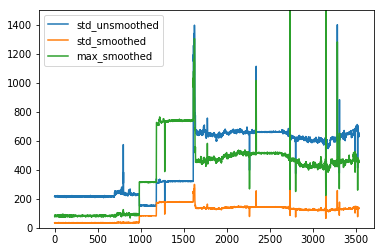

In [123]:
plt.plot(quality_metric_array["std_unsmoothed"].values, label = "std_unsmoothed")
plt.plot(quality_metric_array["std_smoothed"].values, label = "std_smoothed")
plt.plot(quality_metric_array["max_smoothed"].values, label = "max_smoothed")
plt.ylim([0,1500])
plt.legend()
plt.savefig('subtraction_improvement.pdf')

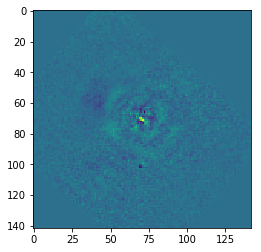

In [95]:
plt.imshow(cube_subtracted[500,:,:])
plt.show()

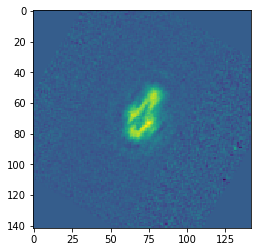

In [97]:
plt.imshow(cube_subtracted[1300,:,:])
plt.show()

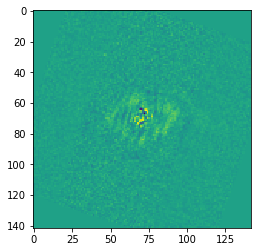

In [98]:
plt.imshow(cube_subtracted[2000,:,:])
plt.show()

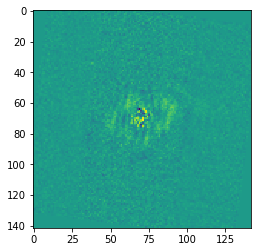

In [99]:
plt.imshow(cube_subtracted[3000,:,:])
plt.show()